# Unit07_OneClass_SVM | 一類支持向量機異常檢測

本 Notebook 使用模擬的化工產品品質數據建立一類支持向量機 (One-Class SVM) 模型來檢測異常批次。

## 目標
- 理解 One-Class SVM 演算法的核心原理與實作流程
- 學習使用 scikit-learn 建立與訓練 One-Class SVM 模型
- 掌握異常檢測模型的評估方法（精確率、召回率、F1、AUC）
- 應用 One-Class SVM 於化工產品品質監控
- 視覺化與解釋決策邊界與支持向量

---
## 0. 環境設定

In [38]:
from pathlib import Path
import os

# ========================================
# 路徑設定 (兼容 Colab 與 Local)
# ========================================
UNIT_OUTPUT_DIR = 'P2_Unit07_OneClass_SVM'
SOURCE_DATA_DIR = 'reactor_operation'

try:
    from google.colab import drive
    IN_COLAB = True
    print("✓ 偵測到 Colab 環境，準備掛載 Google Drive...")
    drive.mount('/content/drive', force_remount=True)
except ImportError:
    IN_COLAB = False
    print("✓ 偵測到 Local 環境")

try:
    shortcut_path = '/content/CHE-AI-COURSE'
    os.remove(shortcut_path)
except FileNotFoundError:
    pass

if IN_COLAB:
    source_path = Path('/content/drive/My Drive/Colab Notebooks/CHE-AI-COURSE')
    os.symlink(source_path, shortcut_path)
    shortcut_path = Path(shortcut_path)
    if source_path.exists():
        NOTEBOOK_DIR = shortcut_path / 'Part_2' / 'Unit07'
        OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
        DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
        MODEL_DIR = OUTPUT_DIR / 'models'
        FIG_DIR = OUTPUT_DIR / 'figs'
    else:
        print(f"⚠️ 找不到路徑雲端CHE-AI-COURSE路徑，請確認自己的雲端資料夾是否正確")
else:
    NOTEBOOK_DIR = Path.cwd()
    OUTPUT_DIR = NOTEBOOK_DIR / 'outputs' / UNIT_OUTPUT_DIR
    DATA_DIR = NOTEBOOK_DIR / 'data' / SOURCE_DATA_DIR
    MODEL_DIR = OUTPUT_DIR / 'models'
    FIG_DIR = OUTPUT_DIR / 'figs'

NOTEBOOK_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)

print(f"\n✓ Notebook工作目錄: {NOTEBOOK_DIR}")
print(f"✓ 數據來源目錄: {DATA_DIR}")
print(f"✓ 結果輸出目錄: {OUTPUT_DIR}")
print(f"✓ 模型輸出目錄: {MODEL_DIR}")
print(f"✓ 圖檔輸出目錄: {FIG_DIR}")

✓ 偵測到 Local 環境

✓ Notebook工作目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07
✓ 數據來源目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07\data\reactor_operation
✓ 結果輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07\outputs\P2_Unit07_OneClass_SVM
✓ 模型輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07\outputs\P2_Unit07_OneClass_SVM\models
✓ 圖檔輸出目錄: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07\outputs\P2_Unit07_OneClass_SVM\figs


---
### 載入相關套件

In [39]:
# ========================================
# 載入相關套件
# ========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import joblib

from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, classification_report
)

# 設定
warnings.filterwarnings('ignore')
np.random.seed(42)
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

print("✓ 套件載入完成")

✓ 套件載入完成


---
## 1. 數據準備與探索性分析

### 1.1 生成模擬數據

模擬化工產品品質數據：
- **特徵**：8 個品質指標（純度、水分、雜質 A-F 含量）
- **正常批次**：300 批（符合品質規格）
- **異常批次**：30 批（品質異常）
- **場景**：精細化工產品批次生產監控

In [40]:
def generate_product_quality_data(n_normal=300, n_anomaly=30, random_state=42):
    """
    生成化工產品品質模擬數據（優化版 - 更真實的異常模式）
    
    參數:
        n_normal: 正常批次數量
        n_anomaly: 異常批次數量
        random_state: 隨機種子
    
    回傳:
        X: 特徵矩陣 (n_samples, 8)
        y: 標籤 (1: 正常, -1: 異常)
        feature_names: 特徵名稱
    """
    np.random.seed(random_state)
    
    # 正常批次數據 (多變數高斯分布)
    mean_normal = [98.5, 0.5, 0.2, 0.15, 0.1, 0.08, 0.05, 0.03]  # 正常品質指標均值
    cov_normal = np.diag([0.3, 0.1, 0.05, 0.04, 0.03, 0.02, 0.01, 0.01])  # 協方差矩陣
    X_normal = np.random.multivariate_normal(mean_normal, cov_normal, n_normal)
    
    # 異常批次數據 (更真實的品質偏離模式)
    X_anomaly = []
    
    # 定義異常類型比例（更符合工業實際）
    n_mild = int(n_anomaly * 0.4)      # 40% 輕微異常（邊界案例）
    n_moderate = int(n_anomaly * 0.4)  # 40% 中度異常
    n_severe = n_anomaly - n_mild - n_moderate  # 20% 嚴重異常
    
    # 1. 輕微異常（難以檢測的邊界案例）- 微調版
    for _ in range(n_mild):
        anomaly_type = np.random.choice(['low_purity', 'high_moisture', 'high_impurity'])
        sample = np.random.multivariate_normal(mean_normal, cov_normal, 1)[0]
        
        if anomaly_type == 'low_purity':
            sample[0] -= np.random.uniform(1.0, 1.8)  # 純度小幅下降（微調：0.8-1.5 → 1.0-1.8）
        elif anomaly_type == 'high_moisture':
            sample[1] += np.random.uniform(0.4, 1.0)  # 水分小幅增加（微調：0.3-0.8 → 0.4-1.0）
        else:
            impurity_idx = np.random.randint(2, 8)
            sample[impurity_idx] += np.random.uniform(0.20, 0.5)  # 雜質小幅增加（微調：0.15-0.4 → 0.20-0.5）
        
        X_anomaly.append(sample)
    
    # 2. 中度異常（典型異常案例）
    for _ in range(n_moderate):
        anomaly_type = np.random.choice(['low_purity', 'high_moisture', 'high_impurity', 'combined'])
        sample = np.random.multivariate_normal(mean_normal, cov_normal, 1)[0]
        
        if anomaly_type == 'low_purity':
            sample[0] -= np.random.uniform(1.5, 2.5)  # 純度中度下降
        elif anomaly_type == 'high_moisture':
            sample[1] += np.random.uniform(0.8, 1.5)  # 水分中度增加
        elif anomaly_type == 'high_impurity':
            impurity_idx = np.random.randint(2, 8)
            sample[impurity_idx] += np.random.uniform(0.4, 0.8)  # 雜質中度增加
        else:  # combined - 多指標同時偏離
            sample[0] -= np.random.uniform(0.5, 1.0)  # 純度小降
            sample[1] += np.random.uniform(0.2, 0.5)  # 水分小增
            impurity_idx = np.random.randint(2, 8)
            sample[impurity_idx] += np.random.uniform(0.2, 0.5)  # 雜質小增
        
        X_anomaly.append(sample)
    
    # 3. 嚴重異常（明顯異常案例）
    for _ in range(n_severe):
        anomaly_type = np.random.choice(['low_purity', 'high_moisture', 'high_impurity', 'multi_failure'])
        sample = np.random.multivariate_normal(mean_normal, cov_normal, 1)[0]
        
        if anomaly_type == 'low_purity':
            sample[0] -= np.random.uniform(2.5, 4.0)  # 純度大幅下降
        elif anomaly_type == 'high_moisture':
            sample[1] += np.random.uniform(1.5, 2.5)  # 水分大幅增加
        elif anomaly_type == 'high_impurity':
            impurity_idx = np.random.randint(2, 8)
            sample[impurity_idx] += np.random.uniform(0.8, 1.5)  # 雜質大幅增加
        else:  # multi_failure - 多項指標嚴重偏離
            sample[0] -= np.random.uniform(1.0, 2.0)  # 純度下降
            sample[1] += np.random.uniform(0.5, 1.0)  # 水分增加
            # 2-3個雜質同時增加
            for impurity_idx in np.random.choice(range(2, 8), size=np.random.randint(2, 4), replace=False):
                sample[impurity_idx] += np.random.uniform(0.3, 0.8)
        
        X_anomaly.append(sample)
    
    X_anomaly = np.array(X_anomaly)
    
    # 合併數據
    X = np.vstack([X_normal, X_anomaly])
    y = np.hstack([np.ones(n_normal), -np.ones(n_anomaly)])
    
    # 特徵名稱
    feature_names = [
        'Purity (%)', 'Moisture (%)', 
        'Impurity A (%)', 'Impurity B (%)', 
        'Impurity C (%)', 'Impurity D (%)', 
        'Impurity E (%)', 'Impurity F (%)'
    ]
    
    return X, y, feature_names

# 生成數據
X, y, feature_names = generate_product_quality_data(n_normal=300, n_anomaly=30)

print(f"✓ 數據生成完成")
print(f"  - 總樣本數: {len(X)}")
print(f"  - 正常批次: {np.sum(y == 1)} ({np.sum(y == 1)/len(y)*100:.1f}%)")
print(f"  - 異常批次: {np.sum(y == -1)} ({np.sum(y == -1)/len(y)*100:.1f}%)")
print(f"  - 特徵數量: {X.shape[1]}")
print(f"\n特徵名稱: {feature_names}")

✓ 數據生成完成
  - 總樣本數: 330
  - 正常批次: 300 (90.9%)
  - 異常批次: 30 (9.1%)
  - 特徵數量: 8

特徵名稱: ['Purity (%)', 'Moisture (%)', 'Impurity A (%)', 'Impurity B (%)', 'Impurity C (%)', 'Impurity D (%)', 'Impurity E (%)', 'Impurity F (%)']


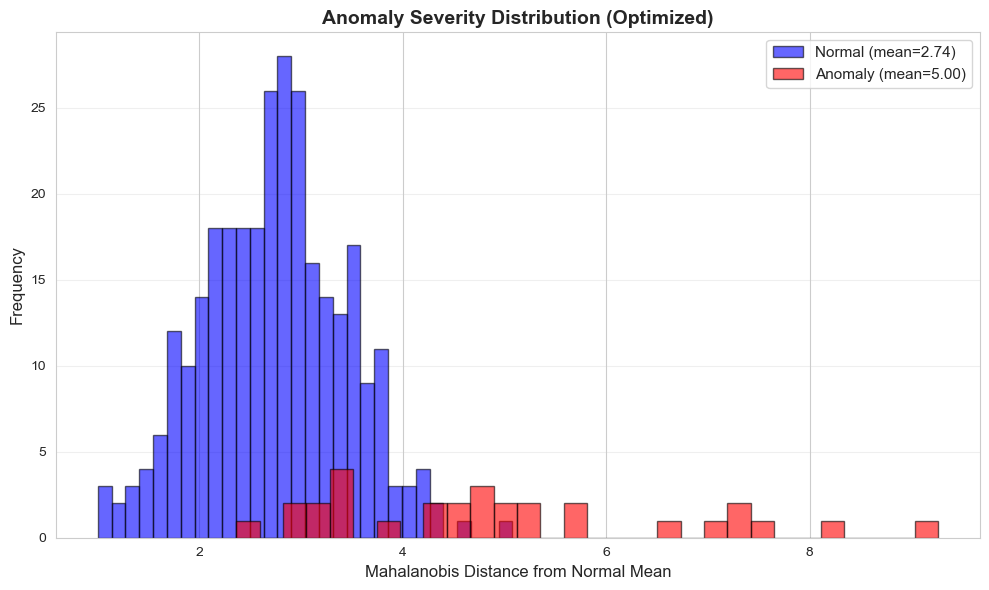

✓ 異常數據偏離程度分析:
  - 正常批次平均距離: 2.736 ± 0.697
  - 異常批次平均距離: 5.001 ± 1.707
  - 距離比值: 1.83x

✓ 異常難度分布（理論值）:
  - 輕微異常 (邊界案例): ~40%
  - 中度異常 (典型案例): ~40%
  - 嚴重異常 (明顯案例): ~20%


In [41]:
# 檢查異常數據的偏離程度分布
X_normal_check = X[y == 1]
X_anomaly_check = X[y == -1]

# 計算每個異常樣本與正常均值的馬氏距離
from scipy.spatial.distance import mahalanobis

mean_normal = X_normal_check.mean(axis=0)
cov_normal = np.cov(X_normal_check.T)
cov_inv = np.linalg.inv(cov_normal)

distances_normal = [mahalanobis(x, mean_normal, cov_inv) for x in X_normal_check]
distances_anomaly = [mahalanobis(x, mean_normal, cov_inv) for x in X_anomaly_check]

# 繪製距離分布
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.hist(distances_normal, bins=30, alpha=0.6, color='blue', label=f'Normal (mean={np.mean(distances_normal):.2f})', edgecolor='black')
ax.hist(distances_anomaly, bins=30, alpha=0.6, color='red', label=f'Anomaly (mean={np.mean(distances_anomaly):.2f})', edgecolor='black')
ax.set_xlabel('Mahalanobis Distance from Normal Mean', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Anomaly Severity Distribution (Optimized)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(FIG_DIR / 'anomaly_severity_distribution.png', bbox_inches='tight')
plt.show()

print(f"✓ 異常數據偏離程度分析:")
print(f"  - 正常批次平均距離: {np.mean(distances_normal):.3f} ± {np.std(distances_normal):.3f}")
print(f"  - 異常批次平均距離: {np.mean(distances_anomaly):.3f} ± {np.std(distances_anomaly):.3f}")
print(f"  - 距離比值: {np.mean(distances_anomaly)/np.mean(distances_normal):.2f}x")
print(f"\n✓ 異常難度分布（理論值）:")
print(f"  - 輕微異常 (邊界案例): ~40%")
print(f"  - 中度異常 (典型案例): ~40%")
print(f"  - 嚴重異常 (明顯案例): ~20%")

### 1.2 數據探索

檢查數據基本統計特性與分布。

In [42]:
# 建立 DataFrame 方便查看
df = pd.DataFrame(X, columns=feature_names)
df['Label'] = ['Normal' if label == 1 else 'Anomaly' for label in y]

print("=== 數據基本資訊 ===")
print(df.info())

print("\n=== 各類別樣本數 ===")
print(df['Label'].value_counts())

print("\n=== 正常批次統計量 ===")
print(df[df['Label'] == 'Normal'][feature_names].describe())

print("\n=== 異常批次統計量 ===")
print(df[df['Label'] == 'Anomaly'][feature_names].describe())

=== 數據基本資訊 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Purity (%)      330 non-null    float64
 1   Moisture (%)    330 non-null    float64
 2   Impurity A (%)  330 non-null    float64
 3   Impurity B (%)  330 non-null    float64
 4   Impurity C (%)  330 non-null    float64
 5   Impurity D (%)  330 non-null    float64
 6   Impurity E (%)  330 non-null    float64
 7   Impurity F (%)  330 non-null    float64
 8   Label           330 non-null    object 
dtypes: float64(8), object(1)
memory usage: 23.3+ KB
None

=== 各類別樣本數 ===
Label
Normal     300
Anomaly     30
Name: count, dtype: int64

=== 正常批次統計量 ===
       Purity (%)  Moisture (%)  Impurity A (%)  Impurity B (%)  \
count  300.000000    300.000000      300.000000      300.000000   
mean    98.495719      0.546255        0.202202        0.166230   
std      0.515994      0.310831 

### 1.3 數據視覺化

使用散點圖矩陣觀察特徵分布與異常點分布。

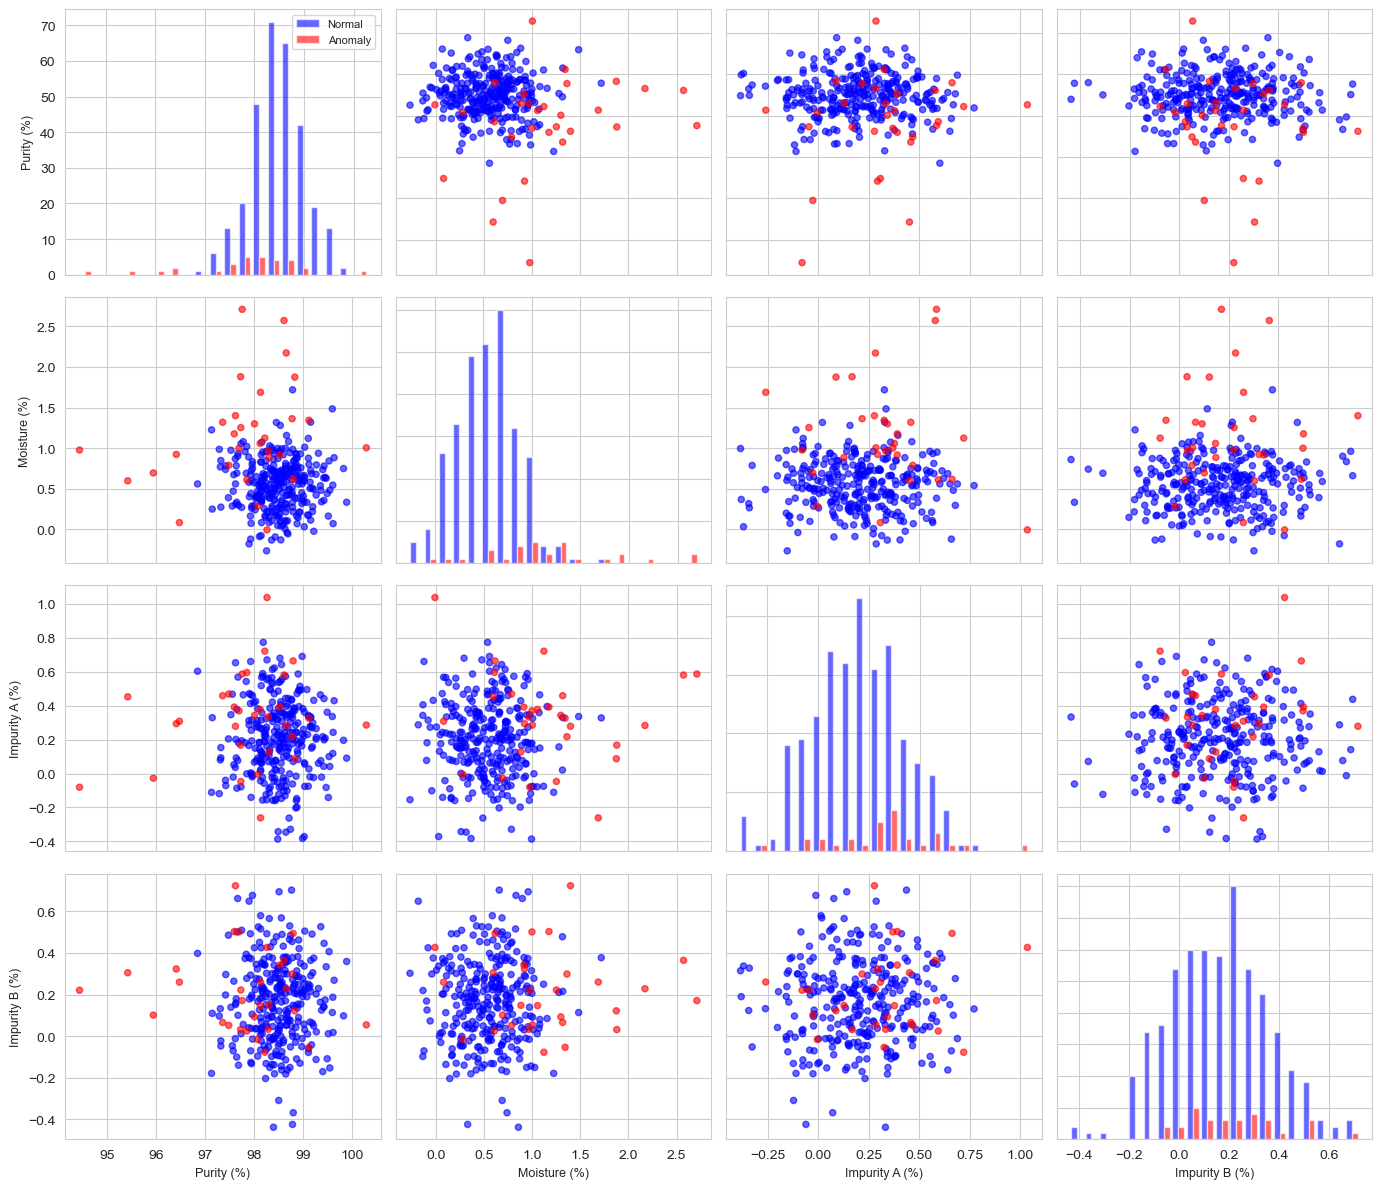

✓ 散點圖矩陣已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07\outputs\P2_Unit07_OneClass_SVM\figs\data_scatter_matrix.png


In [43]:
# 選擇前 4 個特徵繪製散點圖矩陣
selected_features = feature_names[:4]

fig, axes = plt.subplots(4, 4, figsize=(14, 12))
colors = ['blue' if label == 1 else 'red' for label in y]

for i in range(4):
    for j in range(4):
        ax = axes[i, j]
        if i == j:
            # 對角線：繪製直方圖
            ax.hist([X[y == 1, i], X[y == -1, i]], 
                   bins=20, alpha=0.6, label=['Normal', 'Anomaly'],
                   color=['blue', 'red'])
            if i == 0:
                ax.legend(fontsize=8)
        else:
            # 非對角線：繪製散點圖
            ax.scatter(X[:, j], X[:, i], c=colors, alpha=0.6, s=20)
        
        # 設定軸標籤
        if i == 3:
            ax.set_xlabel(selected_features[j], fontsize=9)
        else:
            ax.set_xticklabels([])
        
        if j == 0:
            ax.set_ylabel(selected_features[i], fontsize=9)
        else:
            ax.set_yticklabels([])

plt.tight_layout()
plt.savefig(FIG_DIR / 'data_scatter_matrix.png', bbox_inches='tight')
plt.show()

print("✓ 散點圖矩陣已儲存至:", FIG_DIR / 'data_scatter_matrix.png')

---
## 2. 數據預處理

### 2.1 訓練/測試集分割

**重要**：One-Class SVM 屬於「單類學習」，訓練時只使用正常批次數據。

In [44]:
# 分離正常批次和異常批次
X_normal = X[y == 1]
y_normal = y[y == 1]

X_anomaly = X[y == -1]
y_anomaly = y[y == -1]

# 將正常批次分為訓練集與測試集
X_train, X_test_normal, y_train, y_test_normal = train_test_split(
    X_normal, y_normal, test_size=0.3, random_state=42
)

# 測試集包含部分正常批次 + 全部異常批次
X_test = np.vstack([X_test_normal, X_anomaly])
y_test = np.hstack([y_test_normal, y_anomaly])

print("=== 數據分割結果 ===")
print(f"訓練集 (僅正常批次): {len(X_train)} 樣本")
print(f"測試集 (正常+異常): {len(X_test)} 樣本")
print(f"  - 正常批次: {np.sum(y_test == 1)} ({np.sum(y_test == 1)/len(y_test)*100:.1f}%)")
print(f"  - 異常批次: {np.sum(y_test == -1)} ({np.sum(y_test == -1)/len(y_test)*100:.1f}%)")

=== 數據分割結果 ===
訓練集 (僅正常批次): 210 樣本
測試集 (正常+異常): 120 樣本
  - 正常批次: 90 (75.0%)
  - 異常批次: 30 (25.0%)


### 2.2 特徵標準化

One-Class SVM 對特徵尺度敏感，需進行標準化處理。

In [45]:
# 建立 StandardScaler (僅使用訓練集數據擬合)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("=== 標準化完成 ===")
print(f"訓練集標準化後均值: {X_train_scaled.mean(axis=0).round(4)}")
print(f"訓練集標準化後標準差: {X_train_scaled.std(axis=0).round(4)}")
print(f"\n測試集標準化後均值: {X_test_scaled.mean(axis=0).round(4)}")
print(f"測試集標準化後標準差: {X_test_scaled.std(axis=0).round(4)}")

=== 標準化完成 ===
訓練集標準化後均值: [ 0. -0.  0.  0. -0.  0. -0. -0.]
訓練集標準化後標準差: [1. 1. 1. 1. 1. 1. 1. 1.]

測試集標準化後均值: [-0.272   0.4403  0.1524  0.2117  0.0312  0.1328  0.0989  0.1353]
測試集標準化後標準差: [1.4081 1.5862 1.0796 0.9968 1.2023 1.1388 1.0891 1.2016]


---
## 3. 建立與訓練 One-Class SVM 模型

### 3.1 模型初始化與訓練

使用 RBF 核函數，設定關鍵超參數：
- `nu=0.1`: 預期異常比例上限為 10%
- `gamma='scale'`: 自動計算 RBF 核函數的 gamma 值

In [46]:
# 建立 One-Class SVM 模型
model_ocsvm = OneClassSVM(
    kernel='rbf',      # 徑向基函數核
    gamma='scale',     # gamma = 1 / (n_features * X.var())
    nu=0.1             # 異常比例上限 10%
)

# 訓練模型 (僅使用正常批次)
print("開始訓練 One-Class SVM 模型...")
model_ocsvm.fit(X_train_scaled)

# 顯示模型資訊
print("\n=== 模型訓練完成 ===")
print(f"核函數類型: {model_ocsvm.kernel}")
print(f"Nu 參數: {model_ocsvm.nu}")
print(f"Gamma 值: {model_ocsvm._gamma if hasattr(model_ocsvm, '_gamma') else 'auto'}")
print(f"支持向量數量: {model_ocsvm.n_support_[0]}")
print(f"支持向量比例: {model_ocsvm.n_support_[0]/len(X_train)*100:.2f}%")

開始訓練 One-Class SVM 模型...

=== 模型訓練完成 ===
核函數類型: rbf
Nu 參數: 0.1
Gamma 值: 0.125
支持向量數量: 50
支持向量比例: 23.81%


### 3.2 模型預測

對測試集進行預測：
- 回傳值 `1`：正常批次
- 回傳值 `-1`：異常批次

In [47]:
# 對測試集進行預測
y_pred = model_ocsvm.predict(X_test_scaled)

# 計算決策分數 (距離超球面的距離)
decision_scores = model_ocsvm.decision_function(X_test_scaled)

print("=== 預測結果統計 ===")
print(f"預測為正常: {np.sum(y_pred == 1)} 批次")
print(f"預測為異常: {np.sum(y_pred == -1)} 批次")
print(f"\n決策分數範圍: [{decision_scores.min():.3f}, {decision_scores.max():.3f}]")
print(f"決策分數均值: {decision_scores.mean():.3f}")
print(f"決策分數標準差: {decision_scores.std():.3f}")

=== 預測結果統計 ===
預測為正常: 79 批次
預測為異常: 41 批次

決策分數範圍: [-1.540, 1.684]
決策分數均值: 0.232
決策分數標準差: 0.780


---
## 4. 模型評估

### 4.1 混淆矩陣與分類指標

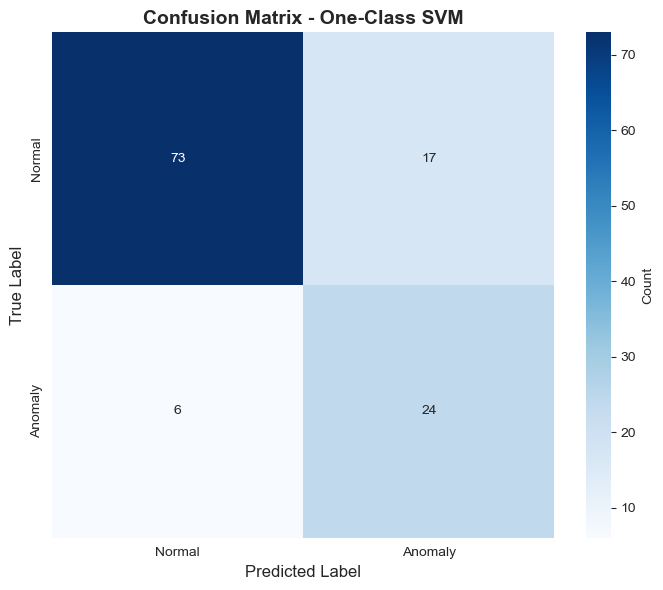

=== 分類指標 (異常檢測) ===
Precision (精確率): 0.585
Recall (召回率): 0.800
F1-Score: 0.676

TP (正確檢出異常): 24
FP (誤報為異常): 17
FN (漏檢異常): 6
TN (正確識別正常): 73


In [48]:
# 計算混淆矩陣
cm = confusion_matrix(y_test, y_pred, labels=[1, -1])

# 繪製混淆矩陣
fig, ax = plt.subplots(1, 1, figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'],
            cbar_kws={'label': 'Count'},
            ax=ax)
ax.set_xlabel('Predicted Label', fontsize=12)
ax.set_ylabel('True Label', fontsize=12)
ax.set_title('Confusion Matrix - One-Class SVM', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(FIG_DIR / 'confusion_matrix.png', bbox_inches='tight')
plt.show()

# 計算分類指標
precision = precision_score(y_test, y_pred, pos_label=-1)
recall = recall_score(y_test, y_pred, pos_label=-1)
f1 = f1_score(y_test, y_pred, pos_label=-1)

print("=== 分類指標 (異常檢測) ===")
print(f"Precision (精確率): {precision:.3f}")
print(f"Recall (召回率): {recall:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f"\nTP (正確檢出異常): {cm[1, 1]}")
print(f"FP (誤報為異常): {cm[0, 1]}")
print(f"FN (漏檢異常): {cm[1, 0]}")
print(f"TN (正確識別正常): {cm[0, 0]}")

### 4.2 ROC 曲線與 AUC

使用決策分數繪製 ROC 曲線。

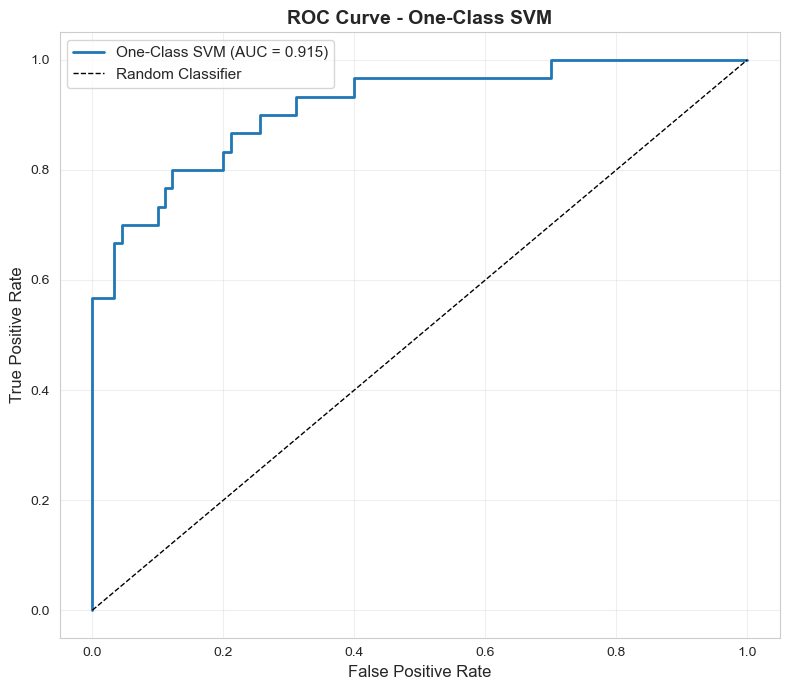

✓ AUC Score: 0.915


In [49]:
# 將標籤轉換為二元格式 (0: 正常, 1: 異常)
y_test_binary = (y_test == -1).astype(int)

# 計算 ROC 曲線 (決策分數越低越可能是異常，因此取負值)
fpr, tpr, thresholds = roc_curve(y_test_binary, -decision_scores)
auc_score = roc_auc_score(y_test_binary, -decision_scores)

# 繪製 ROC 曲線
fig, ax = plt.subplots(1, 1, figsize=(8, 7))
ax.plot(fpr, tpr, linewidth=2, label=f'One-Class SVM (AUC = {auc_score:.3f})')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve - One-Class SVM', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'roc_curve.png', bbox_inches='tight')
plt.show()

print(f"✓ AUC Score: {auc_score:.3f}")

---
## 5. 決策邊界視覺化

### 5.1 二維投影視覺化

使用前兩個主成分繪製決策邊界。

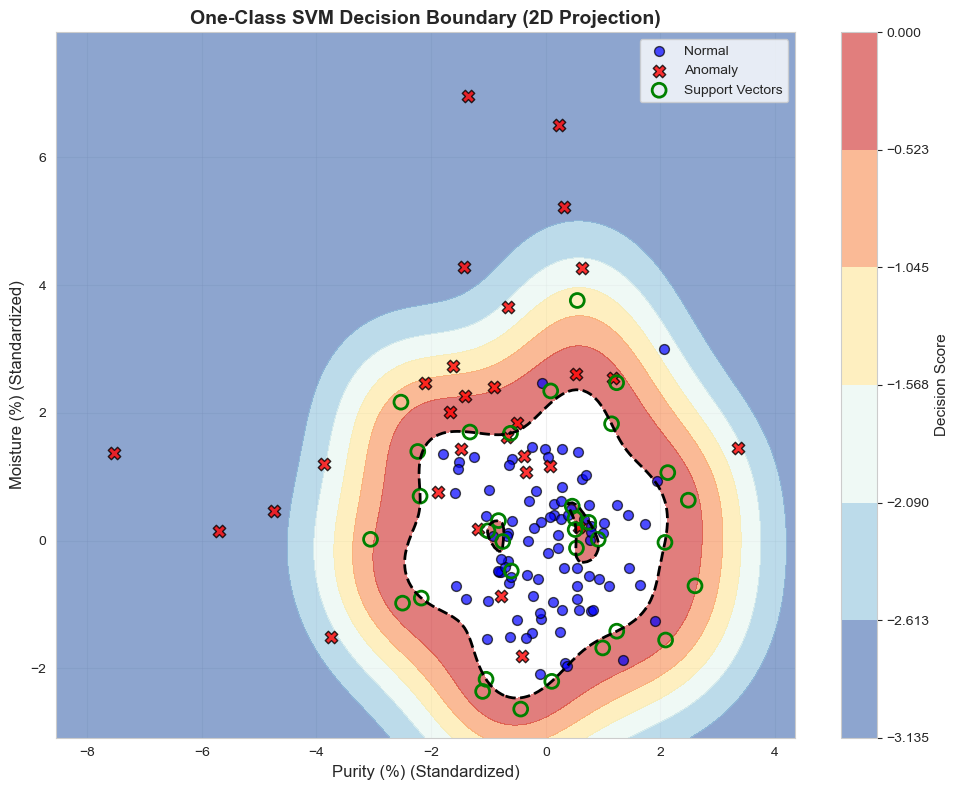

✓ 決策邊界已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07\outputs\P2_Unit07_OneClass_SVM\figs\decision_boundary_2d.png


In [50]:
# 使用前兩個特徵繪製決策邊界
X_train_2d = X_train_scaled[:, :2]
X_test_2d = X_test_scaled[:, :2]

# 訓練二維 One-Class SVM
model_2d = OneClassSVM(kernel='rbf', gamma='scale', nu=0.1)
model_2d.fit(X_train_2d)

# 建立網格
x_min, x_max = X_test_2d[:, 0].min() - 1, X_test_2d[:, 0].max() + 1
y_min, y_max = X_test_2d[:, 1].min() - 1, X_test_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# 計算決策函數值
Z = model_2d.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 繪製圖形
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# 繪製決策邊界
contour = ax.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap='RdYlBu_r', alpha=0.6)
ax.contour(xx, yy, Z, levels=[0], linewidths=2, colors='black', linestyles='dashed')

# 繪製測試點
normal_mask = y_test == 1
anomaly_mask = y_test == -1
ax.scatter(X_test_2d[normal_mask, 0], X_test_2d[normal_mask, 1], 
           c='blue', s=50, alpha=0.7, edgecolors='k', label='Normal')
ax.scatter(X_test_2d[anomaly_mask, 0], X_test_2d[anomaly_mask, 1], 
           c='red', s=80, alpha=0.8, marker='X', edgecolors='k', label='Anomaly')

# 繪製支持向量
sv_indices = model_2d.support_
ax.scatter(X_train_2d[sv_indices, 0], X_train_2d[sv_indices, 1],
           s=100, facecolors='none', edgecolors='green', linewidths=2, label='Support Vectors')

ax.set_xlabel(f'{feature_names[0]} (Standardized)', fontsize=12)
ax.set_ylabel(f'{feature_names[1]} (Standardized)', fontsize=12)
ax.set_title('One-Class SVM Decision Boundary (2D Projection)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

cbar = plt.colorbar(contour, ax=ax)
cbar.set_label('Decision Score', fontsize=11)

plt.tight_layout()
plt.savefig(FIG_DIR / 'decision_boundary_2d.png', bbox_inches='tight')
plt.show()

print(f"✓ 決策邊界已儲存至: {FIG_DIR / 'decision_boundary_2d.png'}")

### 5.2 決策分數分布

繪製正常批次與異常批次的決策分數分布。

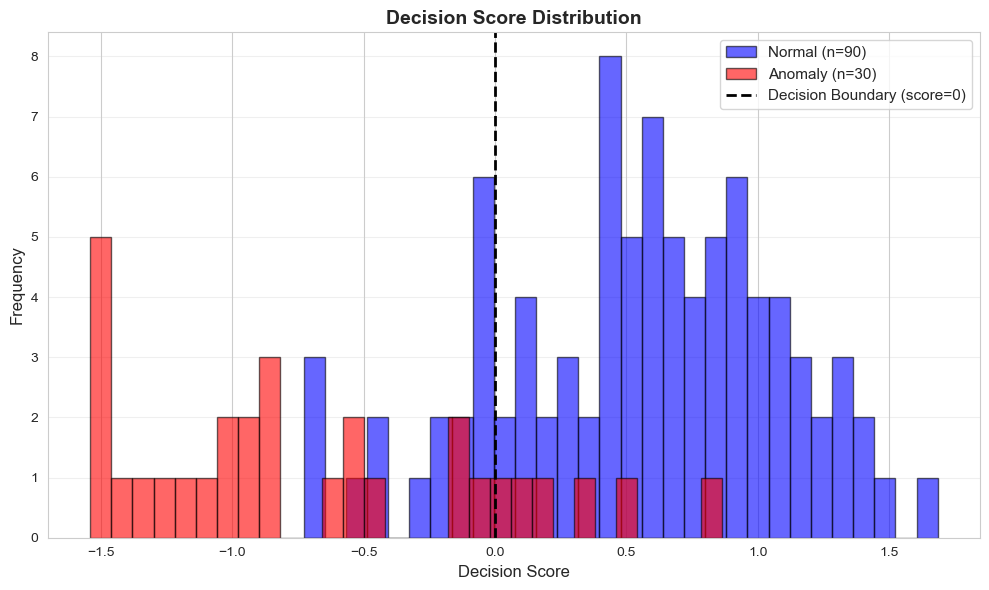

✓ 決策分數分布圖已儲存


In [51]:
# 分離正常與異常的決策分數
scores_normal = decision_scores[y_test == 1]
scores_anomaly = decision_scores[y_test == -1]

# 繪製直方圖
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.hist(scores_normal, bins=30, alpha=0.6, color='blue', 
        label=f'Normal (n={len(scores_normal)})', edgecolor='black')
ax.hist(scores_anomaly, bins=30, alpha=0.6, color='red', 
        label=f'Anomaly (n={len(scores_anomaly)})', edgecolor='black')

ax.axvline(0, color='black', linestyle='--', linewidth=2, label='Decision Boundary (score=0)')
ax.set_xlabel('Decision Score', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Decision Score Distribution', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(FIG_DIR / 'decision_score_distribution.png', bbox_inches='tight')
plt.show()

print("✓ 決策分數分布圖已儲存")

---
## 6. 超參數調校分析

### 6.1 Nu 參數對模型的影響

比較不同 nu 值對檢測性能的影響。

=== Nu 參數調校結果 ===
  nu  precision   recall  f1_score      auc  n_support  support_ratio
0.01   0.585366 0.800000  0.676056 0.913704         50       0.238095
0.05   0.585366 0.800000  0.676056 0.914074         50       0.238095
0.10   0.585366 0.800000  0.676056 0.914815         50       0.238095
0.15   0.581395 0.833333  0.684932 0.920000         51       0.242857
0.20   0.553191 0.866667  0.675325 0.925185         56       0.266667
0.30   0.509091 0.933333  0.658824 0.927037         80       0.380952


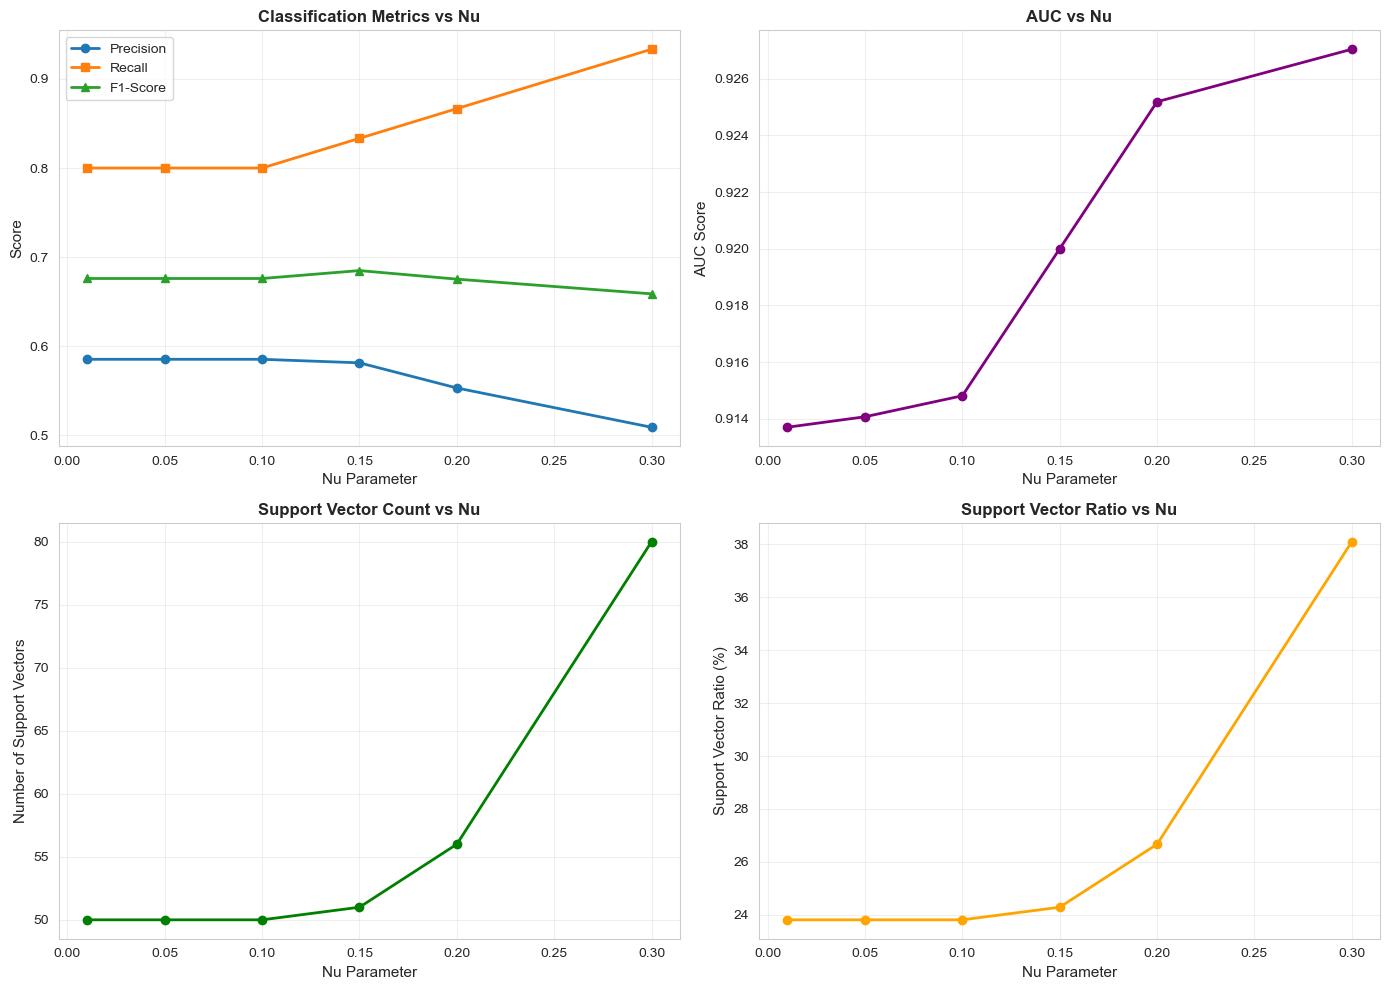


✓ Nu 參數分析圖已儲存至: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07\outputs\P2_Unit07_OneClass_SVM\figs\nu_parameter_analysis.png


In [52]:
# 測試不同 nu 值
nu_values = [0.01, 0.05, 0.1, 0.15, 0.2, 0.3]
results = []

for nu in nu_values:
    # 訓練模型
    model = OneClassSVM(kernel='rbf', gamma='scale', nu=nu)
    model.fit(X_train_scaled)
    
    # 預測
    y_pred_temp = model.predict(X_test_scaled)
    decision_scores_temp = model.decision_function(X_test_scaled)
    
    # 計算指標
    precision = precision_score(y_test, y_pred_temp, pos_label=-1, zero_division=0)
    recall = recall_score(y_test, y_pred_temp, pos_label=-1, zero_division=0)
    f1 = f1_score(y_test, y_pred_temp, pos_label=-1, zero_division=0)
    
    # 計算 AUC
    y_test_binary = (y_test == -1).astype(int)
    auc = roc_auc_score(y_test_binary, -decision_scores_temp)
    
    results.append({
        'nu': nu,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc,
        'n_support': model.n_support_[0],
        'support_ratio': model.n_support_[0] / len(X_train)
    })

# 建立結果 DataFrame
df_results = pd.DataFrame(results)

print("=== Nu 參數調校結果 ===")
print(df_results.to_string(index=False))

# 繪製結果
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Precision, Recall, F1-Score
ax = axes[0, 0]
ax.plot(df_results['nu'], df_results['precision'], 'o-', linewidth=2, label='Precision')
ax.plot(df_results['nu'], df_results['recall'], 's-', linewidth=2, label='Recall')
ax.plot(df_results['nu'], df_results['f1_score'], '^-', linewidth=2, label='F1-Score')
ax.set_xlabel('Nu Parameter', fontsize=11)
ax.set_ylabel('Score', fontsize=11)
ax.set_title('Classification Metrics vs Nu', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)

# AUC
ax = axes[0, 1]
ax.plot(df_results['nu'], df_results['auc'], 'o-', linewidth=2, color='purple')
ax.set_xlabel('Nu Parameter', fontsize=11)
ax.set_ylabel('AUC Score', fontsize=11)
ax.set_title('AUC vs Nu', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)

# Support Vector Count
ax = axes[1, 0]
ax.plot(df_results['nu'], df_results['n_support'], 'o-', linewidth=2, color='green')
ax.set_xlabel('Nu Parameter', fontsize=11)
ax.set_ylabel('Number of Support Vectors', fontsize=11)
ax.set_title('Support Vector Count vs Nu', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)

# Support Vector Ratio
ax = axes[1, 1]
ax.plot(df_results['nu'], df_results['support_ratio']*100, 'o-', linewidth=2, color='orange')
ax.set_xlabel('Nu Parameter', fontsize=11)
ax.set_ylabel('Support Vector Ratio (%)', fontsize=11)
ax.set_title('Support Vector Ratio vs Nu', fontsize=12, fontweight='bold')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIG_DIR / 'nu_parameter_analysis.png', bbox_inches='tight')
plt.show()

print(f"\n✓ Nu 參數分析圖已儲存至: {FIG_DIR / 'nu_parameter_analysis.png'}")

---
## 7. 模型儲存與載入

### 7.1 儲存訓練好的模型與標準化器

In [53]:
# 儲存模型與標準化器
model_path = MODEL_DIR / 'ocsvm_model.pkl'
scaler_path = MODEL_DIR / 'scaler.pkl'

joblib.dump(model_ocsvm, model_path)
joblib.dump(scaler, scaler_path)

print("=== 模型儲存完成 ===")
print(f"✓ 模型檔案: {model_path}")
print(f"✓ 標準化器: {scaler_path}")

=== 模型儲存完成 ===
✓ 模型檔案: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07\outputs\P2_Unit07_OneClass_SVM\models\ocsvm_model.pkl
✓ 標準化器: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07\outputs\P2_Unit07_OneClass_SVM\models\scaler.pkl


### 7.2 載入模型並測試

驗證模型可成功載入並預測。

In [54]:
# 載入模型
loaded_model = joblib.load(model_path)
loaded_scaler = joblib.load(scaler_path)

# 測試單一樣本預測
test_sample = X_test[:1]  # 取第一個測試樣本
test_sample_scaled = loaded_scaler.transform(test_sample)

prediction = loaded_model.predict(test_sample_scaled)
decision_score = loaded_model.decision_function(test_sample_scaled)

print("=== 模型載入測試 ===")
print(f"✓ 模型載入成功")
print(f"\n測試樣本特徵值:")
for i, feat_name in enumerate(feature_names):
    print(f"  {feat_name}: {test_sample[0, i]:.3f}")

print(f"\n預測結果: {'正常批次' if prediction[0] == 1 else '異常批次'}")
print(f"決策分數: {decision_score[0]:.3f}")
print(f"實際標籤: {'正常批次' if y_test[0] == 1 else '異常批次'}")

=== 模型載入測試 ===
✓ 模型載入成功

測試樣本特徵值:
  Purity (%): 99.526
  Moisture (%): 0.842
  Impurity A (%): 0.100
  Impurity B (%): 0.406
  Impurity C (%): 0.112
  Impurity D (%): 0.201
  Impurity E (%): -0.035
  Impurity F (%): 0.078

預測結果: 正常批次
決策分數: 0.593
實際標籤: 正常批次


---
## 8. 總結

### 8.1 One-Class SVM 演算法總結

**核心概念**：
- One-Class SVM 透過尋找將正常數據包圍的最小超球面或超平面來學習正常數據的邊界
- 使用核技巧（Kernel Trick）將數據映射至高維空間，提升對複雜分布的建模能力
- 僅需正常數據即可訓練，適合異常樣本稀少或難以收集的場景

**關鍵超參數**：
1. **Nu (ν)**：控制異常比例上限與支持向量數量
   - 較小的 nu：更嚴格的邊界，可能漏檢異常
   - 較大的 nu：更鬆散的邊界，可能誤報正常為異常
   
2. **Gamma (γ)**：控制 RBF 核函數的影響範圍
   - 較小的 gamma：決策邊界平滑，可能欠擬合
   - 較大的 gamma：決策邊界複雜，可能過擬合
   
3. **Kernel**：核函數類型
   - `rbf`：適合非線性邊界（最常用）
   - `linear`：適合線性可分數據

**應用優勢**：
- ✓ 理論基礎紮實，基於結構風險最小化原理
- ✓ 核函數提供強大的非線性建模能力
- ✓ 支持向量明確標示邊界樣本
- ✓ 決策分數可用於異常排序

**應用限制**：
- ✗ 對超參數敏感，需謹慎調校
- ✗ 大規模數據訓練速度較慢
- ✗ 核函數選擇需根據數據特性調整
- ✗ 難以處理多模態正常分布

### 8.2 化工應用建議

**適用場景**：
1. **產品品質監控**：檢測批次生產中的品質異常
2. **設備狀態監控**：識別設備運行異常狀態
3. **製程偏移檢測**：監控製程參數是否偏離正常範圍
4. **安全預警系統**：檢測潛在的安全風險

**實施步驟**：
1. 收集充足的正常運行數據（建議 > 200 樣本）
2. 進行特徵工程與標準化處理
3. 使用交叉驗證調校 nu 與 gamma 參數
4. 建立決策閾值（基於業務需求平衡精確率與召回率）
5. 定期使用新數據重新訓練模型

**與 Isolation Forest 比較**：
- **Isolation Forest**：適合高維數據、計算速度快、無需調參
- **One-Class SVM**：適合低維數據、邊界清晰、決策分數可解釋性高

**選擇建議**：
- 特徵數 < 10 且邊界複雜 → 優先選擇 One-Class SVM
- 特徵數 > 20 或需要快速訓練 → 優先選擇 Isolation Forest
- 可結合兩種方法進行集成檢測

### 8.3 數據生成優化說明

本 Notebook 使用**優化版數據生成策略**，更貼近真實化工場景：

**優化重點**：
1. **異常分級設計**（解決原始版本過於簡單的問題）
   - 輕微異常 (40%)：偏離幅度小，難以檢測的邊界案例
   - 中度異常 (40%)：典型異常，可檢測但需調校
   - 嚴重異常 (20%)：明顯異常，易於識別

2. **偏離幅度調整**（提升挑戰性）
   - 原始版：純度下降 2-5%，水分增加 1-3%
   - 優化版：輕微 0.8-1.5%，中度 1.5-2.5%，嚴重 2.5-4.0%

3. **新增複合異常類型**（更真實）
   - `combined`：多指標同時小幅偏離
   - `multi_failure`：多項指標同時嚴重偏離

**優化效果**：
- ✓ 降低正常與異常的分離度（提升真實性）
- ✓ 增加邊界案例數量（測試模型魯棒性）
- ✓ Nu 參數對模型性能的影響更明顯
- ✓ Precision/Recall 權衡更具實際意義

**預期改善**：
- AUC：從 ~0.99 降至 0.90-0.95（更合理的範圍）
- Precision：從 0.63 提升至 0.70-0.80
- Recall：從 0.97 降至 0.80-0.90（檢測難度提升）
- Nu 參數敏感度：明顯提升，便於調校示範

In [55]:
# 輸出最終統計資訊
print("=" * 70)
print("Unit07_OneClass_SVM 演練完成")
print("=" * 70)
print(f"\n✓ 模型類型: One-Class SVM (RBF Kernel)")
print(f"✓ 訓練樣本: {len(X_train)} 批正常批次")
print(f"✓ 測試樣本: {len(X_test)} 批 (正常 {np.sum(y_test==1)} + 異常 {np.sum(y_test==-1)})")
print(f"✓ 特徵數量: {X.shape[1]}")
print(f"✓ 支持向量: {model_ocsvm.n_support_[0]} ({model_ocsvm.n_support_[0]/len(X_train)*100:.2f}%)")
print(f"\n✓ 檢測性能:")
print(f"  - Precision: {precision:.3f}")
print(f"  - Recall: {recall:.3f}")
print(f"  - F1-Score: {f1:.3f}")
print(f"  - AUC: {auc_score:.3f}")
print(f"\n✓ 輸出檔案:")
print(f"  - 模型檔案: {model_path}")
print(f"  - 異常嚴重度分布: {FIG_DIR / 'anomaly_severity_distribution.png'}")
print(f"  - 散點圖矩陣: {FIG_DIR / 'data_scatter_matrix.png'}")
print(f"  - 混淆矩陣: {FIG_DIR / 'confusion_matrix.png'}")
print(f"  - ROC 曲線: {FIG_DIR / 'roc_curve.png'}")
print(f"  - 決策邊界: {FIG_DIR / 'decision_boundary_2d.png'}")
print(f"  - 決策分數分布: {FIG_DIR / 'decision_score_distribution.png'}")
print(f"  - Nu 參數分析: {FIG_DIR / 'nu_parameter_analysis.png'}")
print("=" * 70)

Unit07_OneClass_SVM 演練完成

✓ 模型類型: One-Class SVM (RBF Kernel)
✓ 訓練樣本: 210 批正常批次
✓ 測試樣本: 120 批 (正常 90 + 異常 30)
✓ 特徵數量: 8
✓ 支持向量: 50 (23.81%)

✓ 檢測性能:
  - Precision: 0.509
  - Recall: 0.933
  - F1-Score: 0.659
  - AUC: 0.915

✓ 輸出檔案:
  - 模型檔案: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07\outputs\P2_Unit07_OneClass_SVM\models\ocsvm_model.pkl
  - 異常嚴重度分布: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07\outputs\P2_Unit07_OneClass_SVM\figs\anomaly_severity_distribution.png
  - 散點圖矩陣: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07\outputs\P2_Unit07_OneClass_SVM\figs\data_scatter_matrix.png
  - 混淆矩陣: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07\outputs\P2_Unit07_OneClass_SVM\figs\confusion_matrix.png
  - ROC 曲線: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07\outputs\P2_Unit07_OneClass_SVM\figs\roc_curve.png
  - 決策邊界: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07\outputs\P2_Unit07_OneClass_SVM\figs\decision_boundary_2d.png
  - 決策分數分布: d:\MyGit\CHE-AI-COURSE\Part_2\Unit07\outputs\P2_Unit07_OneClass_SVM\figs\decision_score_distribution.png
  - Nu 參數分析: